# Случайные процессы. Прикладной поток.
## Практическое задание 8

Прогнозирование временных рядов.

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 8"`. Квадратные скобки обязательны, внутри них пробела быть не должно. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `8.N.ipynb` и `8.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.
* При выполнении задания можно использовать код с семинара. Во всяком случае ноутбук точно стоит посмотреть.

В файле `electricity.csv` (отсюда) cодержится информация о максимальном спросе на электричество (Consumption) в штате Виктория (Австралия) за $30$-минутные интервалы с $10$ января $2000$ в течении $115$ дней, а так же информация о температуре воздуха (Temperature) за эти же промежутки времени.

In [980]:
import warnings
import itertools
import scipy.stats as sps
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

plt.style.use('fivethirtyeight')

In [981]:
base_time = datetime.datetime(2000, 1, 10, 0, 0, 0)
print("Base datetime:", base_time)

Base datetime: 2000-01-10 00:00:00


In [1008]:
df = pd.read_csv('electricity.csv', index_col=None)
df.head()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,0,3853.475392,20.90,0,0,48
1,1,3683.014105,20.70,1,1,49
2,2,3912.324031,20.50,2,2,50
3,3,3783.881181,20.05,3,3,51
4,4,3554.257244,19.60,4,4,52


<span>1.</span> Нарисуйте графики временных рядов температуры и потребления электричества. Верно ли, что спрос на электричество зависит от температуры воздуха? Для ответа на вопрос используйте коэффициенты корреляции, учитывая условия их применимости.

Для начала проставим колонку дат для данных

In [1011]:
df.set_index([pd.date_range(start=base_time, periods=len(df), freq='30T')], inplace=True)
df.head()

,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
2000-01-10 00:00:00,3853.475392,20.90,0,0,48
2000-01-10 00:30:00,3683.014105,20.70,1,1,49
2000-01-10 01:00:00,3912.324031,20.50,2,2,50
2000-01-10 01:30:00,3783.881181,20.05,3,3,51
2000-01-10 02:00:00,3554.257244,19.60,4,4,52


Построим временной ряд для температуры

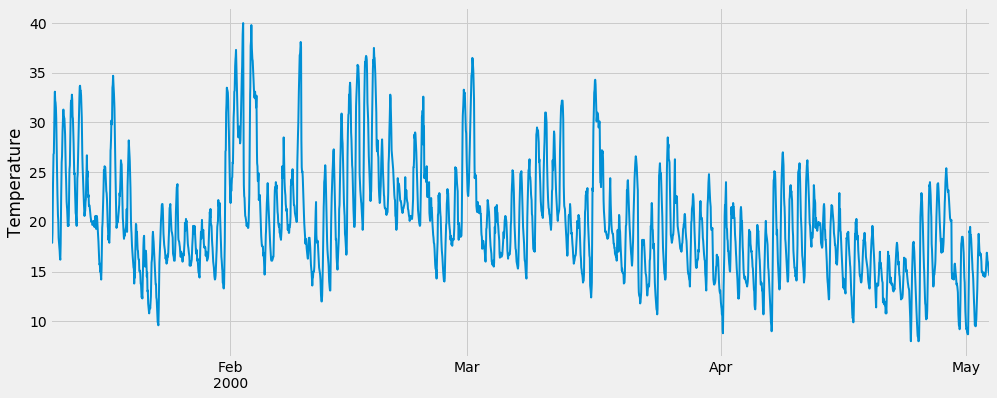

In [1012]:
df['Temperature'].plot(figsize=(15, 6), lw=2)
plt.ylabel('Temperature')
plt.show()

А теперь для энергопотребления

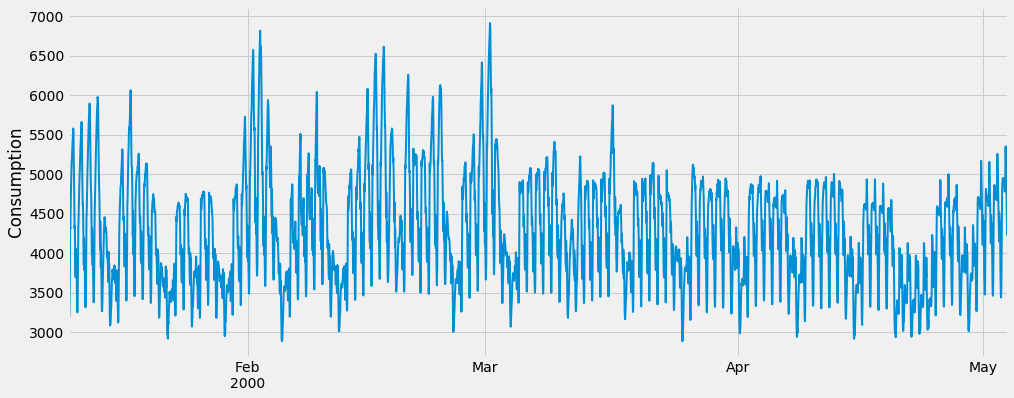

In [1013]:
df['Consumption'].plot(figsize=(15, 6), lw=2)
plt.ylabel('Consumption')
plt.show()

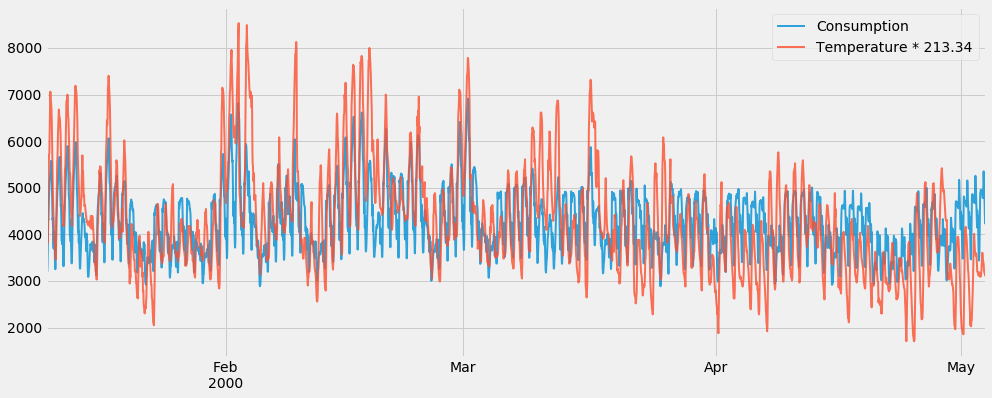

In [1014]:
plot_df = df[['Consumption']]
coef = df['Consumption'].mean() / df['Temperature'].mean()
plot_df['Temperature * ' + str(np.around(coef, 2))] = df['Temperature'] * coef

plot_df.plot(figsize=(15, 6), alpha=0.8, lw=2)
plt.show()

Теперь исследуем на кореляцию температуры и энергопотребления

Для начала посмотрим на точки этой зависимости

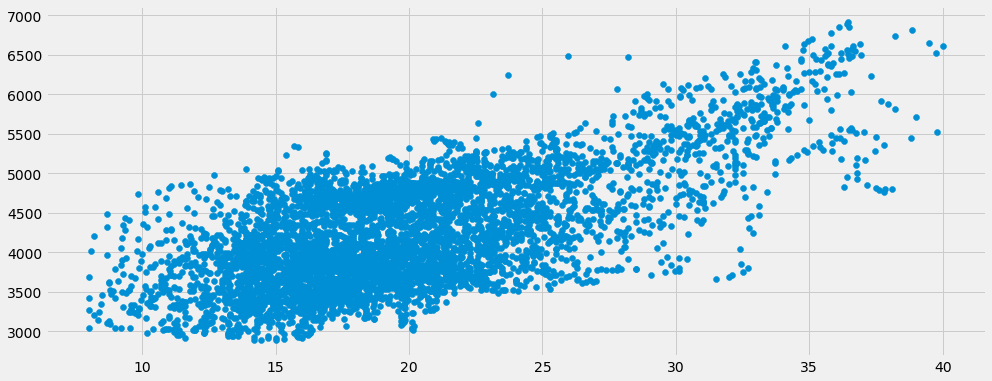

In [1015]:
plt.figure(figsize=(15, 6))
plt.scatter(df['Temperature'], df['Consumption'])
plt.show()

Можно заметить, что данные немного напоминают прямую, поэтому будем пользоваться гипотезой независимости

** Гипотеза независимости ** <br\>
$H_0$: выборки некоррелированы <br\>
$H_1$: выборки зависимы

Напишем функцию для визуализации кореляции

In [1016]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [1017]:
def visualize_correaltion(values1, values2):
    correlation = np.array([ sps.pearsonr  (values1, values2),
                             sps.spearmanr (values1, values2),
                             sps.kendalltau(values1, values2) ])
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 3, 1)
    
    plt.scatter(values1, values2)
    plt.title('Sample')

    ax = fig.add_subplot(1, 3, 2)    
    plt.bar([0, 1, 2], correlation.T[0])
    plt.axhline(0, lw=1, c='black')
    
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['$\\hat{p}$', '$p_s$', '$\\tau$'])
    plt.ylim([-1, 1])
    plt.title('Correlation')

    ax = fig.add_subplot(1, 3, 3)
    plt.bar([0, 1, 2], correlation.T[1])
    plt.axhline(0.05, lw=1, c='red')
    
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['$\\hat{p}$', '$p_s$', '$\\tau$'])
    plt.ylim([0, 1])
    plt.title('Pvalue')

    plt.show()

In [1018]:
def visualize_multipletest(result):
    print("Гипотеза отклоняется:", result[0])
    print("Скорректированные p-values:",result[1])
    
    print("\nГипотеза отклоняется:", np.all(result[0]))

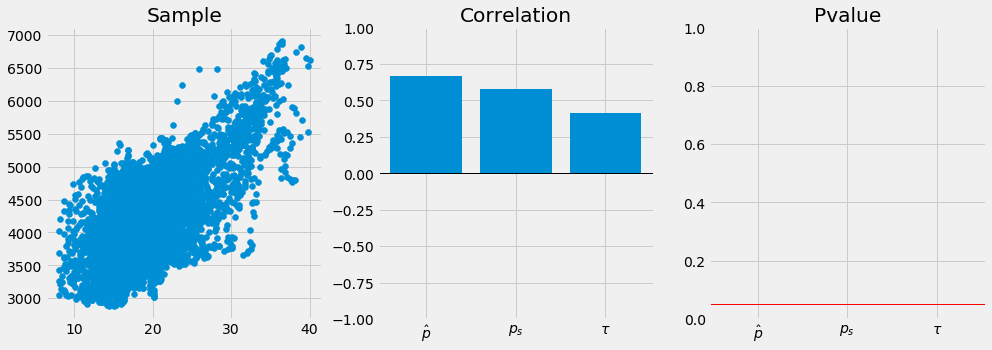

Гипотеза отклоняется: [ True  True  True  True  True  True  True  True  True  True]
Скорректированные p-values: [  3.72119161e-62   5.87688815e-72   4.56598249e-72   3.88256205e-61
   2.21742223e-64   6.06106706e-63   3.20202431e-72   2.16682132e-69
   1.50942963e-59   7.74523497e-68]

Гипотеза отклоняется: True

Гипотеза отклоняется: [ True  True  True  True  True  True  True  True  True  True]
Скорректированные p-values: [  2.10436860e-39   2.60078169e-50   7.29976692e-54   3.00961686e-53
   3.87605249e-51   5.63887311e-46   7.90332695e-51   2.55333536e-48
   1.21170193e-44   7.14744061e-46]

Гипотеза отклоняется: True

Гипотеза отклоняется: [ True  True  True  True  True  True  True  True  True  True]
Скорректированные p-values: [  2.87835043e-38   1.73400583e-48   9.47652929e-51   1.65310017e-49
   2.03418155e-47   6.95166786e-44   3.40642217e-47   2.00876152e-45
   1.27972218e-42   5.76150493e-44]

Гипотеза отклоняется: True



In [1019]:
visualize_correaltion(df['Temperature'], df['Consumption'])

pvalues = [[], [], []]
for test in range(10):
    inds = np.random.choice(len(df), int(len(df) / 10))
    
    correlation = np.array([ sps.pearsonr  (df['Temperature'].iloc[inds], 
                                            df['Consumption'].iloc[inds]),
                             sps.spearmanr (df['Temperature'].iloc[inds], 
                                            df['Consumption'].iloc[inds]),
                             sps.kendalltau(df['Temperature'].iloc[inds], 
                                            df['Consumption'].iloc[inds]) ])
    
    for i in range(3):
        pvalues[i].append(correlation[i][1])

for i in range(3):
    visualize_multipletest(multipletests(pvalues[i], method='bonferroni'))
    print()

# TODO

<span>2.</span> Разделите временной ряд на две части: данные за последнюю неделю (последние $48*7$ измерений) назовем тестовыми данными, а все остальное — обучающими данными. 

In [1020]:
train_df = df.iloc[:-48 * 7]
test_df  = df.iloc[-48 * 7:]

<span>3.</span> Сколько типов сезонностей можно выделить в каждом из двух рядов (спрос на электричество и температура)? С помощью $STL$-декомпозиции в каждом ряде выделите тренд, все типы сезонности, остатки.

In [1021]:
def visualize_seasonal_decompose(decompose):
    fig = plt.figure(figsize=(15, 15))  
    
    ax = fig.add_subplot(4, 1, 1)
    decompose.observed.plot(lw=2)
    plt.ylabel("Observed")
    
    ax = fig.add_subplot(4, 1, 2)
    decompose.trend.plot(lw=2)
    plt.ylabel("Trend")
    
    ax = fig.add_subplot(4, 1, 3)
    decompose.seasonal.plot(lw=2)
    plt.ylabel("Seasonal")
    
    ax = fig.add_subplot(4, 1, 4)
    decompose.resid.plot(lw=2)
    plt.ylabel("Resid")
    
    plt.show()

In [1022]:
from statsmodels.tsa.seasonal import seasonal_decompose

Анализ временного ряда Температуры

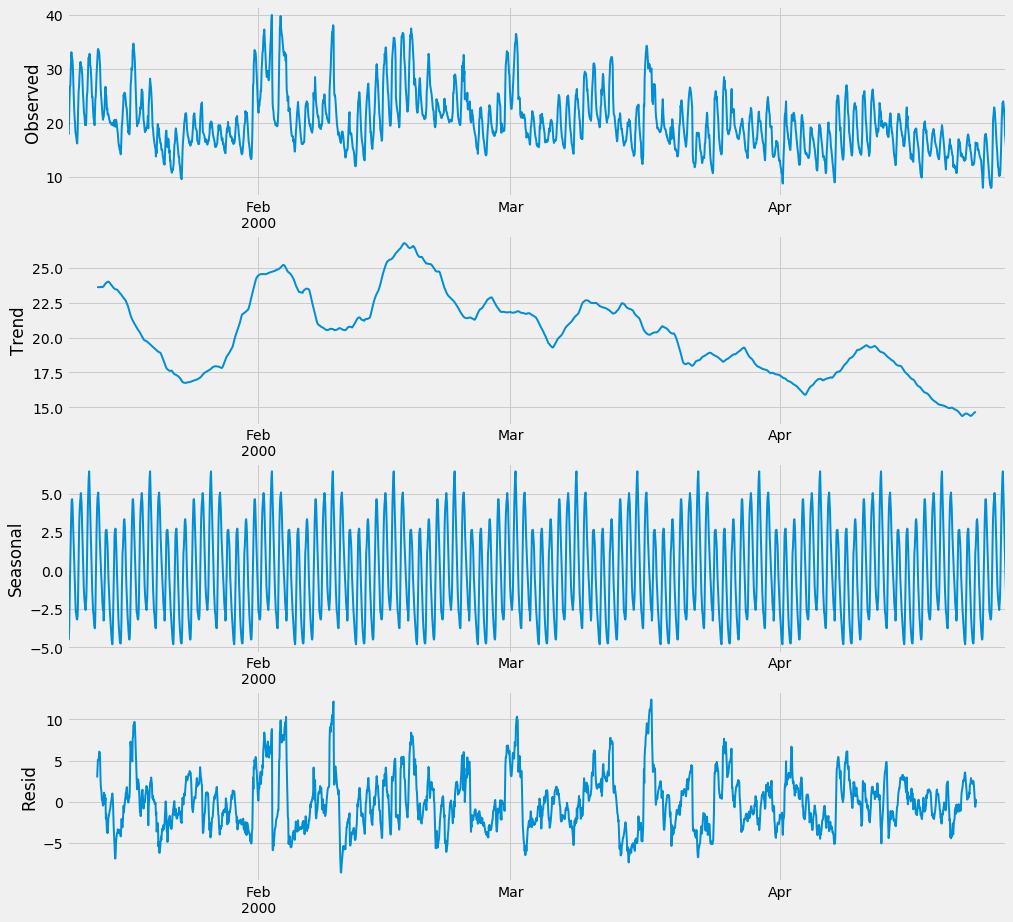

In [1024]:
temperature_decompose_week = seasonal_decompose(train_df['Temperature'], freq=48*7)
visualize_seasonal_decompose(temperature_decompose_week)

temperature_resid_week = temperature_decompose_week.resid[np.isfinite(temperature_decompose_week.resid.values)]

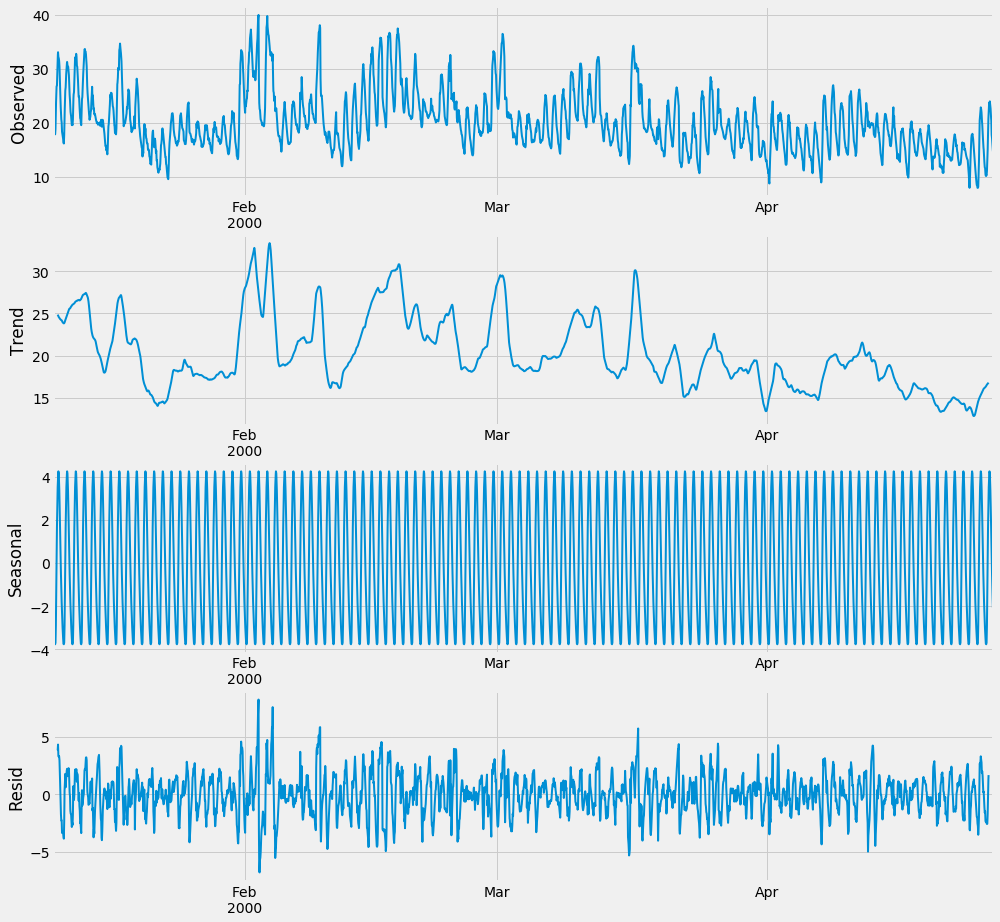

In [1025]:
temperature_decompose_day = seasonal_decompose(train_df['Temperature'], freq=48)
visualize_seasonal_decompose(temperature_decompose_day)

temperature_resid_day = temperature_decompose_day.resid[np.isfinite(temperature_decompose_day.resid.values)]

Анализ временного ряда Потребления

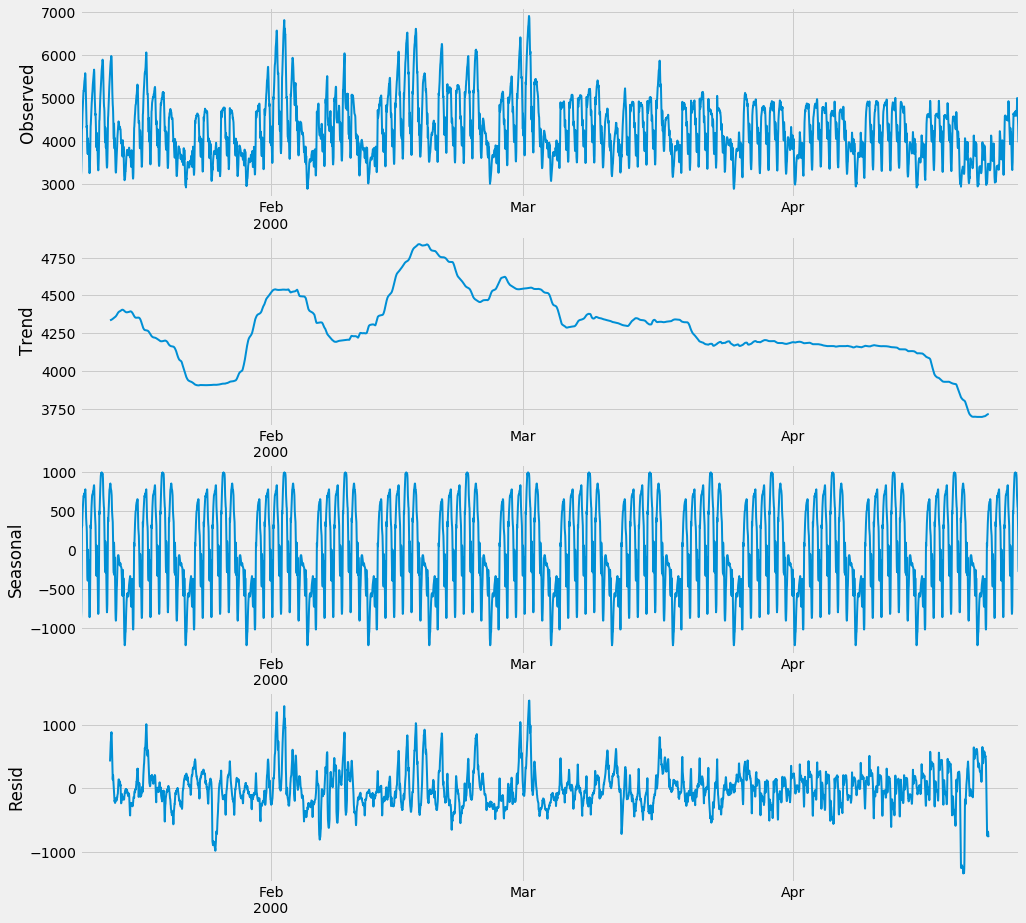

In [1026]:
consumption_decompose_week = seasonal_decompose(train_df['Consumption'], freq=48*7)
visualize_seasonal_decompose(consumption_decompose_week)

consumption_resid_week = consumption_decompose_week.resid[np.isfinite(consumption_decompose_week.resid.values)]

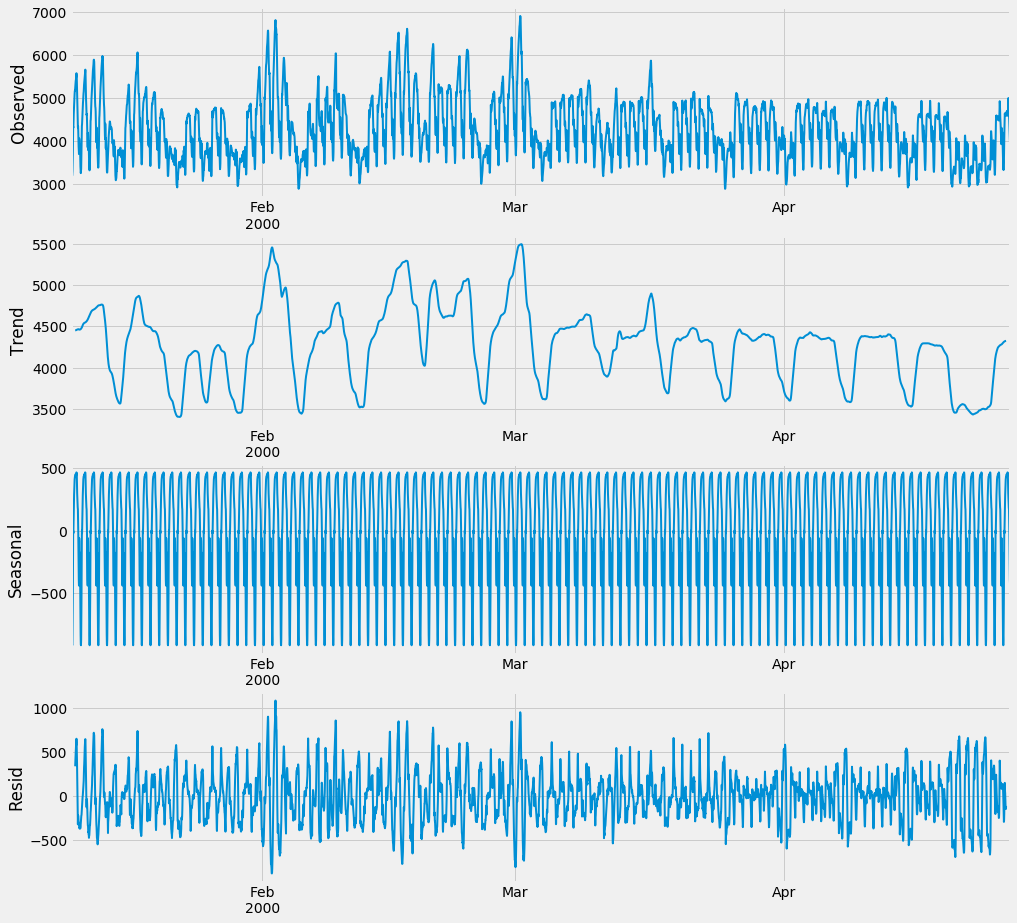

In [1027]:
consumption_decompose_day = seasonal_decompose(train_df['Consumption'], freq=48)
visualize_seasonal_decompose(consumption_decompose_day)

consumption_resid_day = consumption_decompose_day.resid[np.isfinite(consumption_decompose_day.resid.values)]

<span>4.</span> С помощью критерия KPSS проверьте на стационарность исходные ряды и остатки, полученные после применения $STL$-декомпозиции. Не забывайте про множественную проверку гипотез.

** Гипотеза ** <br\>
$H_0$: ряд стационарен <br\>
$H_1$: ряд описывается моделью вида $y_t = \alpha y_{t-1}$

In [1028]:
from statsmodels.tsa.stattools import kpss

In [1029]:
def stationarity_check(values):
    result = kpss(values)
    print(result)
    print("Гипотеза отклоняется:", result[1] < 0.05, end="\n\n")

    pvalues = []
    for test in range(10):
        part = int(len(train_df) / 10)
        pvalues.append(kpss(values[test * part:(test + 1) * part])[1])

    visualize_multipletest(multipletests(np.array(pvalues)/len(pvalues), method='bonferroni'))

In [1030]:
stationarity_check(train_df['Temperature'].values)

(3.3025613539810768, 0.01, 33, {'5%': 0.463, '1%': 0.739, '10%': 0.347, '2.5%': 0.574})
Гипотеза отклоняется: True

Гипотеза отклоняется: [False  True  True  True False  True False  True False False]
Скорректированные p-values: [ 0.05781762  0.01824677  0.01        0.01002732  0.1         0.03057066
  0.06643681  0.01        0.1         0.1       ]

Гипотеза отклоняется: False


In [1031]:
stationarity_check(temperature_resid_week)

(0.01654585169215558, 0.1, 32, {'5%': 0.463, '1%': 0.739, '10%': 0.347, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False  True False False False False False False False  True]
Скорректированные p-values: [ 0.1         0.01852471  0.1         0.1         0.1         0.1         0.1
  0.1         0.1         0.02917793]

Гипотеза отклоняется: False


In [1032]:
stationarity_check(temperature_resid_day)

(0.0066484742102166953, 0.1, 33, {'5%': 0.463, '1%': 0.739, '10%': 0.347, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False False False False False False False False False False]
Скорректированные p-values: [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]

Гипотеза отклоняется: False


In [1033]:
stationarity_check(train_df['Consumption'].values)

(0.98874779975401406, 0.01, 33, {'5%': 0.463, '1%': 0.739, '10%': 0.347, '2.5%': 0.574})
Гипотеза отклоняется: True

Гипотеза отклоняется: [False False  True  True False False False False False  True]
Скорректированные p-values: [ 0.1         0.1         0.04587338  0.03454652  0.1         0.1         0.1
  0.1         0.1         0.0403611 ]

Гипотеза отклоняется: False


In [1034]:
stationarity_check(consumption_resid_week)

(0.017763900134228409, 0.1, 32, {'5%': 0.463, '1%': 0.739, '10%': 0.347, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False  True False False False False False False False False]
Скорректированные p-values: [ 0.1         0.01        0.1         0.1         0.1         0.1         0.1
  0.1         0.1         0.09417342]

Гипотеза отклоняется: False


In [1035]:
stationarity_check(consumption_resid_day)

(0.0035004299103796278, 0.1, 33, {'5%': 0.463, '1%': 0.739, '10%': 0.347, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False False False False False False False False False False]
Скорректированные p-values: [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]

Гипотеза отклоняется: False


<span>5.</span> С помощью преобразований исходных рядов приведите их к стационарным. По графикам $ACF$ и $PACF$ подберите параметры модели $SARIMA\left(p, d, q\right) \times \left(P, D, Q\right)_s$.

In [1036]:
def autocorrelation(data):
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=50, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=50, ax=ax2)
    plt.show()

(0.005437996760345217, 0.1, 32, {'5%': 0.463, '1%': 0.739, '10%': 0.347, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False False False False False False False False False False]
Скорректированные p-values: [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]

Гипотеза отклоняется: False


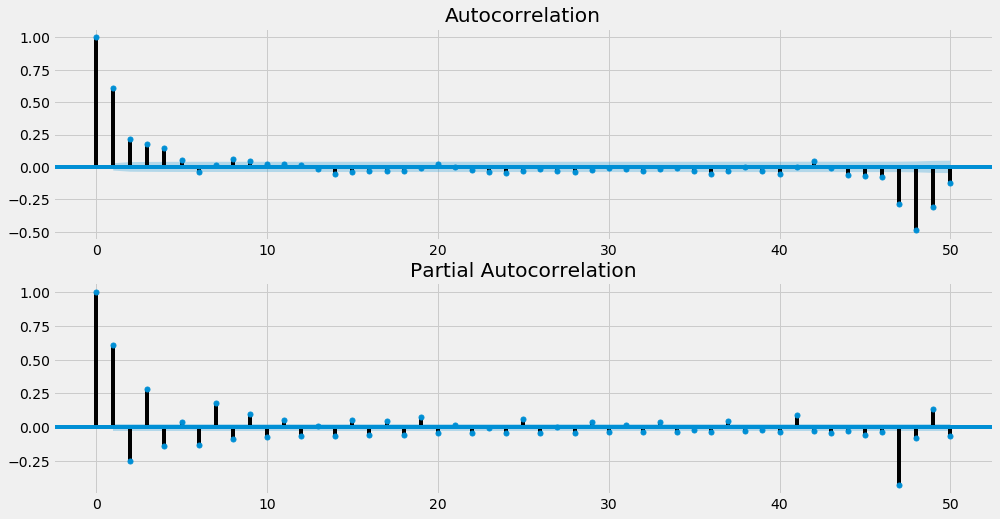

In [1068]:
temperature = np.array(train_df['Temperature'])

temperature = temperature[48*7:] - temperature[:-48*7]
temperature = temperature[48:] - temperature[:-48]
temperature = temperature[1:] - temperature[:-1]

stationarity_check(temperature)
autocorrelation(temperature)

(0.0047888883620005075, 0.1, 32, {'5%': 0.463, '1%': 0.739, '10%': 0.347, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False False False False False False False False False False]
Скорректированные p-values: [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]

Гипотеза отклоняется: False


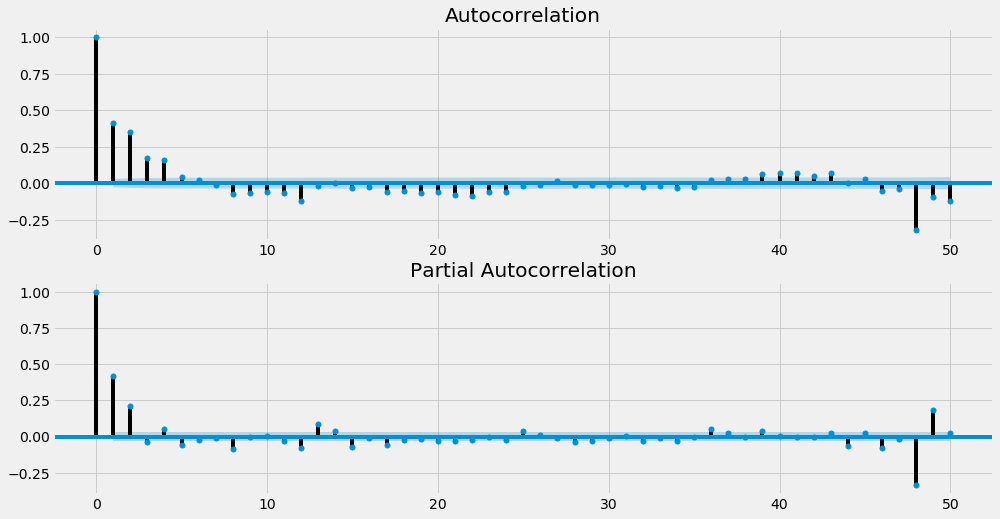

In [1066]:
temperature = np.array(train_df['Consumption'])

temperature = temperature[48*7:] - temperature[:-48*7]
temperature = temperature[48:] - temperature[:-48]
temperature = temperature[1:] - temperature[:-1]

stationarity_check(temperature)
autocorrelation(temperature)

<span>6.</span> С помощью поиска по сетке вокруг выбранных параметров подберите оптимальные параметры по значению $AIC$. Учтите, что из сделанных ранее преобразований ряда нужно оставить лишь некоторые. Другие, например, одна из сезонностей будут учтены параметрами модели.

In [1060]:
p = range(5)
q = range(3)
d = [1]
P = range(5)
D = [1]
Q = range(3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 48) for x in list(itertools.product(P, D, Q))]

In [1061]:
warnings.filterwarnings('ignore')

temperature = np.array(train_df['Temperature'])
temperature = temperature[48*7:] - temperature[:-48*7]

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        try:
            model = sm.tsa.statespace.SARIMAX(temperature, 
                                              order=param, seasonal_order=param_seasonal, 
                                              enforce_stationarity=False, enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}12 – AIC:{}'.format(param, param_seasonal, model.aic))
        except Exception as e:
            print(e)
            continue

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


could not broadcast input array from shape (0,0) into shape (49,49)



KeyboardInterrupt: 

<span>7.</span> Постройте прогнозы модели с оптимальными параметрами на неделю вперед. Посчитайте качество прогноза по сравнению с реальными данными на тестовом интервале, используя метрику $MSE$ (см. презентацию).

<span>8.</span> Добавьте в модель предсказания электричества экзогенные факторы:

<span>(a)</span> Дневную и месячную сезонность (очевидно, они известны заранее). Однако, в том виде как они записаны в таблице применять не хорошо &mdash; может работать плохо, поэтому стоит использовать гармоники Фурье &mdash; синусы с периодом, делящим период сезонности. Их использование может позволить учесть сложные сезонности.

<span>(b)</span> Значения температуры, используя на тестовом интервале времени истинные значения температуры (нечестный способ).

<span>(c)</span> Значения температуры, используя на тестовом интервале времени предсказания значений температуры.

<span>(d)</span> Вместе (a) и (c).

<span>(e)</span> * Использование значений температуры по частям — для получения прогноза $\widehat{\text{y}}_T + h|_𝑇$ строится своя модель по временному ряду $y_h, \dots, y_𝑇$ с рядом экзогенного фактора $x_1, \dots, x_{𝑇−h}$.Тогда для получения прогноза𝑦 $\widehat{\text{y}}_T + h|_𝑇$ нужно знать значения $x_{𝑇−h+1}, \dots, x_𝑇$ , которые известны на момент построения модели.

<span>(f)</span> * Вместе (a) и (e).

<span>9.</span> Сравните все предсказания по метрике $MSE$.